# Proyek Klasifikasi Gambar: 10 Animals Dataset
- **Nama:** Muhamad Alif Ramadhan
- **Email:** muhamadalifram@gmail.com
- **ID Dicoding:** malifram

## Import Semua Packages/Library yang Digunakan

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
from tqdm.notebook import tqdm as tq
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import MobileNetV2

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
print(tf.__version__)

2.18.0


## Data Preparation

### Data Loading

In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"muhamadaliframadhan","key":"6508c467882f1b01aeede331a4b444de"}'}

In [5]:
!kaggle datasets download -d alessiocorrado99/animals10
!unzip animals10.zip

Streaming output truncated to the last 5000 lines.
  inflating: raw-img/ragno/OIP-MVQChNQpHiMZEVMPehrvoAHaE6.jpeg  
  inflating: raw-img/ragno/OIP-MVdIFDAFpNyK_XCpwkDIWgHaFj.jpeg  
  inflating: raw-img/ragno/OIP-MYY_8k5AHqMJwTCNXfH6rwHaFj.jpeg  
  inflating: raw-img/ragno/OIP-MZEVXuoMsATG8u_UuTQ6hAHaE8.jpeg  
  inflating: raw-img/ragno/OIP-MZg0tznDRE95AMfyuutuYAHaE6.jpeg  
  inflating: raw-img/ragno/OIP-M_r9DkR2X5gP0P5-z8wPYQHaE7.jpeg  
  inflating: raw-img/ragno/OIP-M_xDUSzjlF3-w9XHCm93cgHaFF.jpeg  
  inflating: raw-img/ragno/OIP-MbI4-bMyutRX3X382IAVcQAAAA.jpeg  
  inflating: raw-img/ragno/OIP-MbMksZdD7gomsC9fd6cpKgHaHJ.jpeg  
  inflating: raw-img/ragno/OIP-Md4AMcvjaHcivJqeW06wEwHaFW.jpeg  
  inflating: raw-img/ragno/OIP-MgCgailkT5XkO1XczzQCngHaLK.jpeg  
  inflating: raw-img/ragno/OIP-MgrKq05YHGXsgj1AmYIyJQHaE8.jpeg  
  inflating: raw-img/ragno/OIP-MhRGx7d8nbnHBuqrsO00EQHaFo.jpeg  
  inflating: raw-img/ragno/OIP-MiVgMXcKGQdog2KGe7i0YQHaHh.jpeg  
  inflating: raw-img/ragno/OIP-Mis0lJf3

Data Preparation

In [6]:
selected_classes = [
    "cane", "ragno", "gallina"
]

dataset_dir = "raw-img"

for class_name in os.listdir(dataset_dir):
    class_dir = os.path.join(dataset_dir, class_name)
    if class_name not in selected_classes:
        shutil.rmtree(class_dir)
        print(f"Deleted class: {class_name}")

print("Unnecessary classes removed!")

Deleted class: scoiattolo
Deleted class: mucca
Deleted class: farfalla
Deleted class: elefante
Deleted class: pecora
Deleted class: cavallo
Deleted class: gatto
Unnecessary classes removed!


In [7]:
translate = {
    "cane": "dog", "gallina": "chicken", "ragno": "spider"
}

source_dir = "raw-img"
dataset_dir = os.path.join(source_dir, "dataset")
os.makedirs(dataset_dir, exist_ok=True)

for folder_name in os.listdir(source_dir):
    source_folder_path = os.path.join(source_dir, folder_name)
    if os.path.isdir(source_folder_path) and folder_name not in ["train", "test", "dataset"]:
        translated_name = translate.get(folder_name, folder_name)
        dataset_folder_path = os.path.join(dataset_dir, translated_name)
        os.makedirs(dataset_folder_path, exist_ok=True)

        for file_name in os.listdir(source_folder_path):
            file_path = os.path.join(source_folder_path, file_name)

            if os.path.isfile(file_path):
                shutil.copy2(file_path, dataset_folder_path)

print("Proses penyalinan ke folder dataset selesai.")

Proses penyalinan ke folder dataset selesai.


Dataset Checking

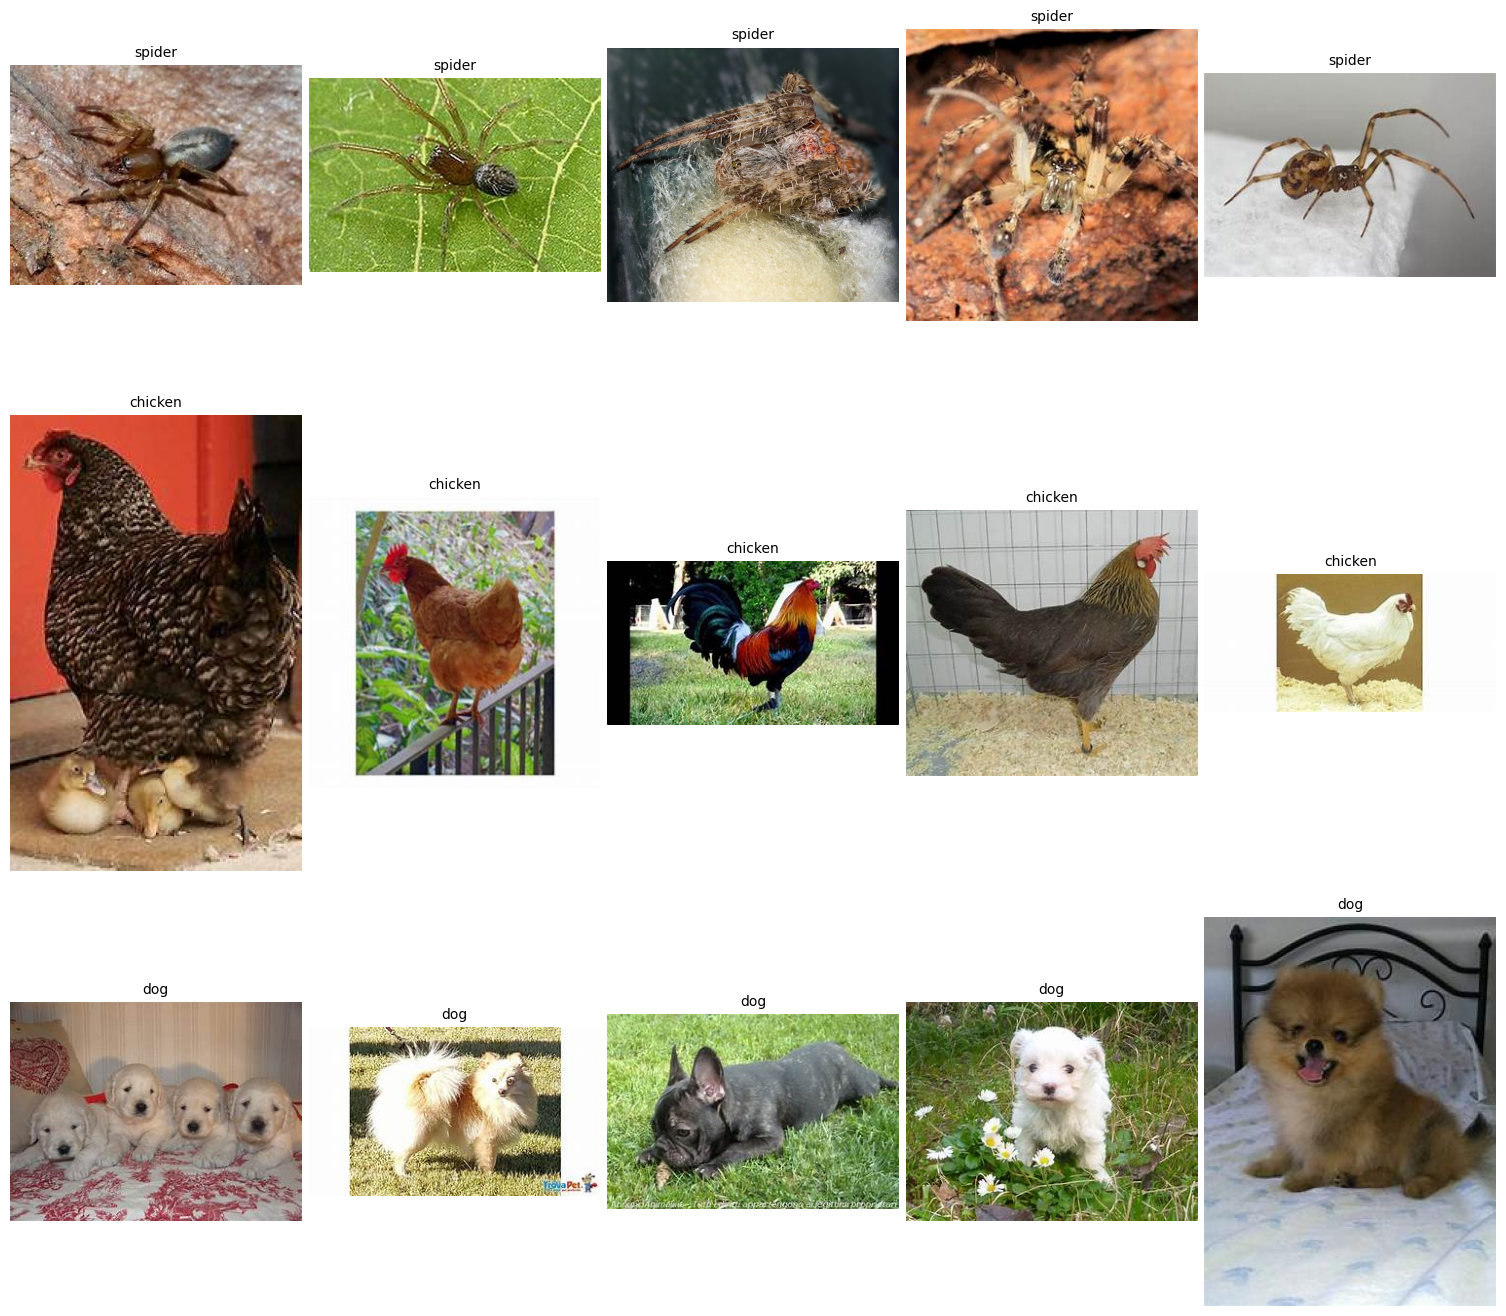

In [8]:
valid_extensions = ('.jpg', '.jpeg', '.png')

animal_image = {}
path = "raw-img/"
path_sub = os.path.join(path, "dataset")

for class_name in os.listdir(path_sub):
    class_folder = os.path.join(path_sub, class_name)

    if os.path.isdir(class_folder):
        animal_image[class_name] = [f for f in os.listdir(class_folder)
                                    if f.lower().endswith(valid_extensions)]

fig, axs = plt.subplots(len(animal_image.keys()), 5, figsize=(15, 15))

for i, class_name in enumerate(animal_image.keys()):
    if len(animal_image[class_name]) >= 5:
        images = np.random.choice(animal_image[class_name], 5, replace=False)
    else:
        images = animal_image[class_name]

    for j, image_name in enumerate(images):
        img_path = os.path.join(path_sub, class_name, image_name)
        img = Image.open(img_path).convert("RGB")
        axs[i, j].imshow(img)
        axs[i, j].set_title(class_name, fontsize=10)
        axs[i, j].axis('off')

fig.tight_layout(pad=0.5)
plt.show()

### Data Preprocessing

Plot Distribusi

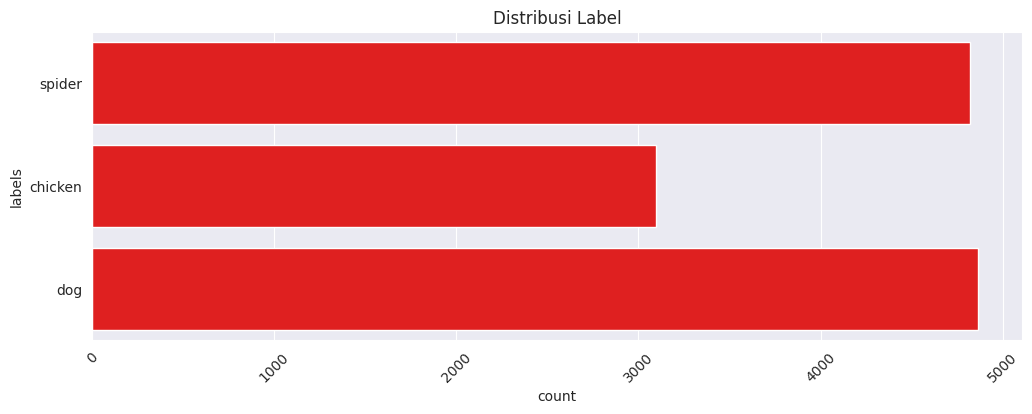

In [9]:
animal_path = "raw-img/dataset/"

file_name = []
labels = []
full_path = []

for path, subdirs, files in os.walk(animal_path):
  for name in files:
    full_path.append(os.path.join(path, name))
    labels.append(path.split("/")[-1])
    file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path, "file_name":file_name, "labels":labels})

label = distribution_train['labels']
plt.figure(figsize=(12, 4))
sns.set_style("darkgrid")
plot_data = sns.countplot(y=label, color="red")
plt.title("Distribusi Label")
plt.xticks(rotation=45)
plt.show()

Data Augmentasi

In [10]:
def preprocess_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    if image is None:
        print(f"Gambar tidak ditemukan: {image_path}")
        return None

    if image.dtype == np.float64:
        image = (255 * image / np.max(image)).astype(np.uint8)
        print(f"Gambar diubah dari CV_64F ke CV_8U: {image_path}")
    return image

def anticlockwise_rotation(img):
    img = cv2.resize(img, (224, 224))
    sudut = random.randint(0, 180)
    return rotate(img, sudut)

def clockwise_rotation(img):
    img = cv2.resize(img, (224, 224))
    sudut = random.randint(0, 180)
    return rotate(img, -sudut)

def flip_up_down(img):
    img = cv2.resize(img, (224, 224))
    return np.flipud(img)

def add_brightness(img):
    img = cv2.resize(img, (224, 224))
    img = adjust_gamma(img, gamma=0.5, gain=1)
    return img

def blur_image(img):
    img = cv2.resize(img, (224, 224))
    return cv2.GaussianBlur(img, (9, 9), 0)

def sheared(img):
    img = cv2.resize(img, (224, 224))
    transform = AffineTransform(shear=0.2)
    shear_image = warp(img, transform, mode="wrap")
    return shear_image

def warp_shift(img):
    img = cv2.resize(img, (224, 224))
    transform = AffineTransform(translation=(0, 40))
    warp_image = warp(img, transform, mode="wrap")
    return warp_image

Augmentasi Data Chicken

In [11]:
transformations = {
    'rotate anticlockwise': anticlockwise_rotation,
    'rotate clockwise': clockwise_rotation,
    'warp shift': warp_shift,
    'blurring image': blur_image,
    'add brightness': add_brightness,
    'flip up down': flip_up_down,
    'shear image': sheared
}

images_path = "raw-img/dataset/chicken"
augmented_path = "raw-img/dataset/chicken"
images = []

for im in os.listdir(images_path):
    images.append(os.path.join(images_path,im))

images_to_generate=1500
i=1

while i<=images_to_generate:
    image=random.choice(images)
    try:
        original_image = io.imread(image)
        transformed_image=None
        n = 0
        transformation_count = random.randint(1, len(transformations))

        while n <= transformation_count:
            key = random.choice(list(transformations))
            transformed_image = transformations[key](original_image)
            n = n + 1

        new_image_path= "%s/augmented_image_%s.jpg" %(augmented_path, i)
        transformed_image = img_as_ubyte(transformed_image)
        cv2.imwrite(new_image_path, transformed_image)
        i =i+1
    except ValueError as e:
        print('could not read the',image ,':',e,'hence skipping it.')

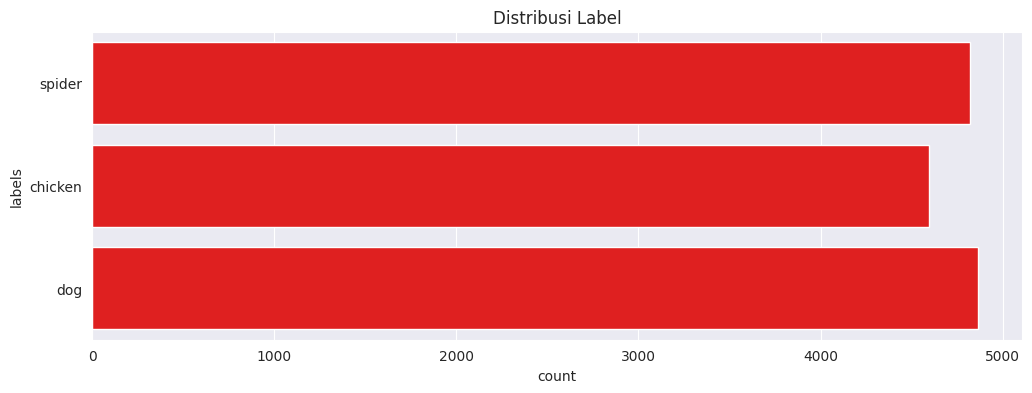

In [12]:
animal_path = "raw-img/dataset/"

file_name = []
labels = []
full_path = []

for path, subdirs, files in os.walk(animal_path):
  for name in files:
    full_path.append(os.path.join(path, name))
    labels.append(path.split("/")[-1])
    file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path, "file_name":file_name, "labels":labels})

label = distribution_train['labels']
plt.figure(figsize=(12, 4))
sns.set_style("darkgrid")
plot_data = sns.countplot(y=label, color="red")
plt.title("Distribusi Label")
plt.show()

#### Split Dataset

In [13]:
mypath = "raw-img/dataset/"

file_name = []
labels = []
full_path = []
for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

df = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})
df.groupby(['labels']).size()

,0
labels,
chicken,4598
dog,4863
spider,4821


In [14]:
X= df['path']
y= df['labels']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=300)

In [15]:
df_tr = pd.DataFrame({'path':X_train,'labels':y_train,'set':'train'})
df_te = pd.DataFrame({'path':X_test,'labels':y_test,'set':'test'})

In [16]:
df_all = pd.concat([df_tr, df_te], ignore_index=True)

print('===================================================== \n')
print(df_all.groupby(['set', 'labels']).size(), '\n')
print('===================================================== \n')

print(df_all.sample(5))

datasource_path = "raw-img/dataset/"
dataset_path = "Dataset-Final/"


set    labels 
test   chicken     954
       dog         966
       spider      937
train  chicken    3644
       dog        3897
       spider     3884
dtype: int64 


                                                    path   labels    set
741    raw-img/dataset/dog/OIP-kPMz6LsjexuTo52-VtKEPA...      dog  train
1996   raw-img/dataset/spider/e832b10f28f2053ed1584d0...   spider  train
4379    raw-img/dataset/chicken/augmented_image_1274.jpg  chicken  train
8227     raw-img/dataset/chicken/augmented_image_451.jpg  chicken  train
13186  raw-img/dataset/spider/OIP-yPcAcmqAt-WrHbIl-nb...   spider   test


In [17]:
for index, row in tq(df_all.iterrows()):
    file_path = row['path']
    if os.path.exists(file_path) == False:
            file_path = os.path.join(datasource_path,row['labels'],row['image'].split('.')[0])

    if os.path.exists(os.path.join(dataset_path,row['set'],row['labels'])) == False:
        os.makedirs(os.path.join(dataset_path,row['set'],row['labels']))

    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(dataset_path,row['set'],row['labels'],destination_file_name)

    if os.path.exists(file_dest) == False:
        shutil.copy2(file_path,file_dest)

0it [00:00, ?it/s]

Image Data Generator

In [18]:
TRAIN_DIR = "Dataset-Final/train/"
TEST_DIR = "Dataset-Final/test/"

classes = ["chicken", "dog", "spider"]

print("Jumlah gambar di setiap kelas:")
for class_name in classes:
    train_path = os.path.join(TRAIN_DIR, class_name)
    test_path = os.path.join(TEST_DIR, class_name)

    train_count = len(os.listdir(train_path)) if os.path.exists(train_path) else 0
    test_count = len(os.listdir(test_path)) if os.path.exists(test_path) else 0

    print(f"{class_name.capitalize()}:")
    print(f"  - Train: {train_count} gambar")
    print(f"  - Test: {test_count} gambar")

Jumlah gambar di setiap kelas:
Chicken:
  - Train: 3644 gambar
  - Test: 954 gambar
Dog:
  - Train: 3897 gambar
  - Test: 966 gambar
Spider:
  - Train: 3884 gambar
  - Test: 937 gambar


In [40]:
datagen = ImageDataGenerator(rescale=1/255.,
                             rotation_range=5,
                             width_shift_range=0.05,
                             height_shift_range=0.05,
                             shear_range=0.1,
                             zoom_range=0.1,
                             horizontal_flip=True,
                             fill_mode='nearest'
                             )
test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = datagen.flow_from_directory(TRAIN_DIR,
                                              batch_size=64,
                                              target_size=(150,150),
                                              color_mode="rgb",
                                              class_mode='categorical',
                                              shuffle=True)

test_generator = test_datagen.flow_from_directory(TEST_DIR,
                                                  batch_size=1,
                                                  target_size=(150,150),
                                                  color_mode="rgb",
                                                  class_mode='categorical',
                                                  shuffle=False)

Found 11425 images belonging to 3 classes.
Found 2857 images belonging to 3 classes.


## Modelling

In [50]:
model_1 = Sequential()

model_1.add(Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(150,150,3)))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D((2, 2)))

model_1.add(Conv2D(128, (4, 4),padding='same', activation='relu'))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D((2, 2)))

model_1.add(Conv2D(256, (7, 7), padding='same', activation='relu'))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D((2, 2)))

model_1.add(Flatten())
model_1.add(Dense(256, activation='relu', kernel_regularizer=l2(0.001)))
model_1.add(Dropout(0.5))
model_1.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
model_1.add(Dropout(0.3))
model_1.add(Dense(3, activation='softmax'))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model_1.compile(optimizer=optimizer,
                loss='categorical_crossentropy',
                metrics=['accuracy'])


print(model_1.summary())

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_26 (Conv2D)                   │ (None, 150, 150, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_26               │ (None, 150, 150, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_26 (MaxPooling2D)      │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_27 (Conv2D)                   │ (None, 75, 75, 128)         │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_27               │ (None, 75, 75, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_27 (MaxPooling2D)      │ (None, 37, 37, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_28 (Conv2D)                   │ (None, 37, 37, 256)         │       1,605,888 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_28               │ (None, 37, 37, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_28 (MaxPooling2D)      │ (None, 18, 18, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_8 (Flatten)                  │ (None, 82944)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 256)                 │      21,233,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,007,875 (87.77 MB)

 Trainable params: 23,006,979 (87.76 MB)

 Non-trainable params: 896 (3.50 KB)

None


In [51]:
train_counts = {}
for class_name in os.listdir(TRAIN_DIR):
    class_path = os.path.join(TRAIN_DIR, class_name)
    if os.path.isdir(class_path):
        train_counts[class_name] = len([
            f for f in os.listdir(class_path)
            if os.path.isfile(os.path.join(class_path, f))
        ])

total_train_images = sum(train_counts.values())

class_weights = {}
for idx, (class_name, count) in enumerate(train_counts.items()):
    if count > 0:
        weight = (1 / count) * (total_train_images / 2.0)
        class_weights[idx] = weight
    else:
        class_weights[idx] = 0

print("Jumlah gambar per kelas:")
for class_name, count in train_counts.items():
    print(f"{class_name}: {count}")

print("\nClass Weights:")
for idx, weight in class_weights.items():
    print(f"Class {idx} ({list(train_counts.keys())[idx]}): {weight}")

Jumlah gambar per kelas:
spider: 3884
chicken: 3644
dog: 3897

Class Weights:
Class 0 (spider): 1.4707775489186405
Class 1 (chicken): 1.5676454445664105
Class 2 (dog): 1.4658711829612523


In [52]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history_1 = model_1.fit(
    train_generator,
    epochs=30,
    batch_size=64,
    validation_data=test_generator,
    class_weight=class_weights,
    callbacks=[early_stopping]
)

Epoch 1/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 120s 623ms/step - accuracy: 0.5176 - loss: 3.0650 - val_accuracy: 0.3287 - val_loss: 8.6430
Epoch 2/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 99s 556ms/step - accuracy: 0.6449 - loss: 1.9159 - val_accuracy: 0.6143 - val_loss: 1.5805
Epoch 3/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 140s 544ms/step - accuracy: 0.6897 - loss: 1.8143 - val_accuracy: 0.7658 - val_loss: 1.2534
Epoch 4/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 95s 528ms/step - accuracy: 0.7318 - loss: 1.6658 - val_accuracy: 0.7707 - val_loss: 1.2205
Epoch 5/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 100s 559ms/step - accuracy: 0.7566 - loss: 1.5928 - val_accuracy: 0.7994 - val_loss: 1.1968
Epoch 6/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 94s 525ms/step - accuracy: 0.7916 - loss: 1.4355 - val_accuracy: 0.8085 - val_loss: 1.1313
Epoch 7/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 94s 528ms/step - accuracy: 0.8002 - loss: 1.4020 - val_accuracy: 0.8022 - val_loss: 1.0872
Epoch 8/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 96s 537ms/step - accuracy: 0.8196 - loss

## Evaluasi dan Visualisasi

In [53]:
score = model_1.evaluate(train_generator)

print('Loss: {:.4f}'.format(score[0]))
print('Accuracy: {:.4f}'.format(score[1]))

179/179 ━━━━━━━━━━━━━━━━━━━━ 79s 436ms/step - accuracy: 0.9583 - loss: 0.4235
Loss: 0.4159
Accuracy: 0.9613


In [54]:
score = model_1.evaluate(test_generator)

print('Loss: {:.4f}'.format(score[0]))
print('Accuracy: {:.4f}'.format(score[1]))

2857/2857 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - accuracy: 0.8925 - loss: 0.6323
Loss: 0.5646
Accuracy: 0.9226


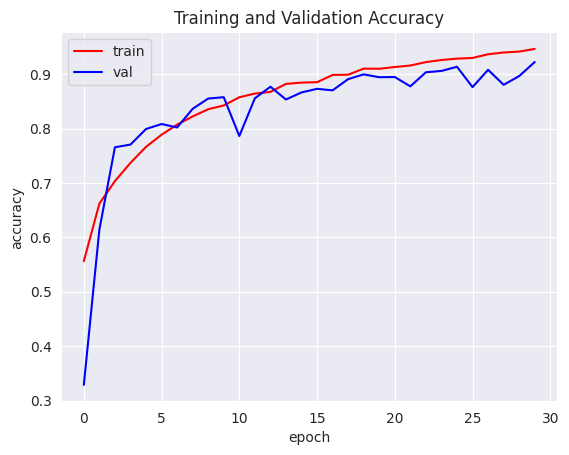

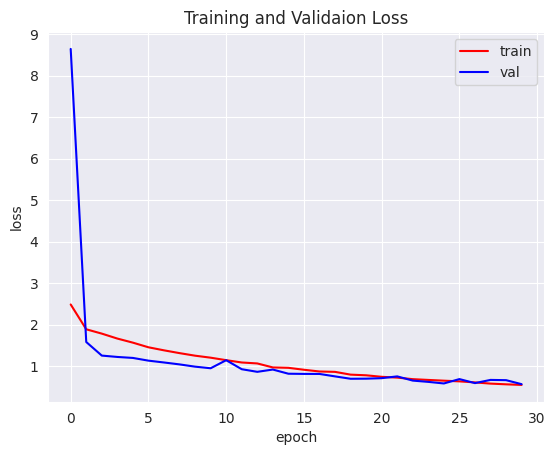

In [55]:
acc = history_1.history['accuracy']
val_acc = history_1.history['val_accuracy']
loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.title('Training and Validaion Loss')
plt.show()

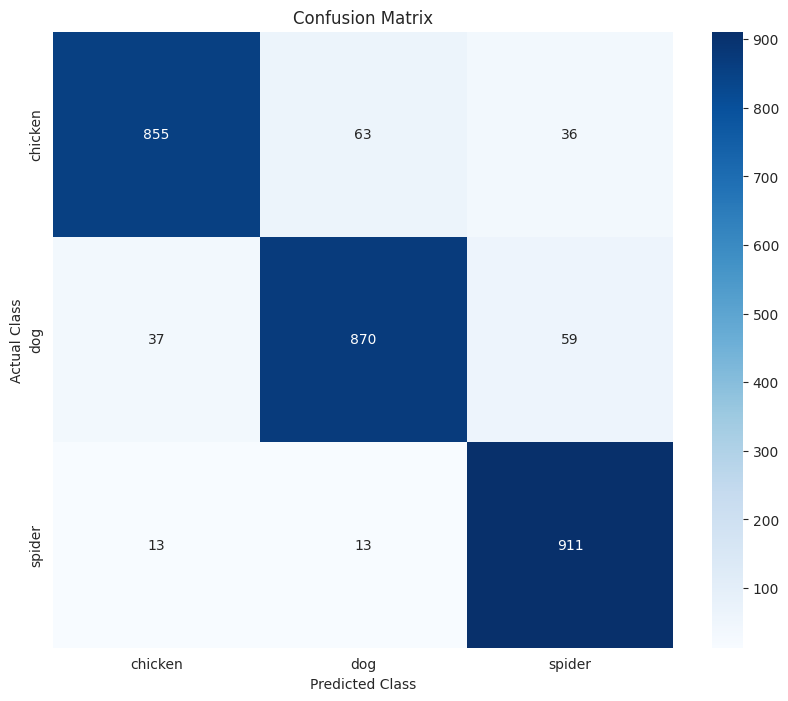


Classification Report:
              precision    recall  f1-score   support

     chicken     0.9448    0.8962    0.9198       954
         dog     0.9197    0.9006    0.9100       966
      spider     0.9056    0.9723    0.9377       937

    accuracy                         0.9226      2857
   macro avg     0.9233    0.9230    0.9225      2857
weighted avg     0.9234    0.9226    0.9224      2857



In [56]:
test_generator.reset()

preds_1 = model_1.predict(test_generator, verbose=0)

predicted_classes = np.argmax(preds_1, axis=1)

true_classes = test_generator.classes

class_labels = ["chicken", "dog", "spider"]

cm = confusion_matrix(true_classes, predicted_classes)
cm_df = pd.DataFrame(cm, index=class_labels, columns=class_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.ylabel("Actual Class")
plt.xlabel("Predicted Class")
plt.show()

print("\nClassification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels, digits=4))

## Konversi Model

Menginstal Dependensi

In [57]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 62.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 66.5 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2


In [58]:
!pip install tensorflow-serving-api

In [59]:
!pip install tflite_support

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.3/243.3 kB 15.7 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.6
    Uninstalling protobuf-4.25.6:
      Successfully uninstalled protobuf-4.25.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-status 1.62.3 requires protobuf>=4.21.6, but you have protobuf 3.20.3 which is incompatible.
tensorflow-metadata 1.16.1 requires protobuf<6.0.0dev,>=4.25.2; python_version >= "3.11", but you have protobuf 3.20.3 which is incompatible.


Menyimpan Model dalam Format SavedModel

In [60]:
from google.colab import files

tf.saved_model.save(model_1, "saved_model/my_model/1")
shutil.make_archive('my_model', 'zip', 'saved_model', 'my_model')
files.download('my_model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

TensorFlow.js

In [61]:
!tensorflowjs_converter --input_format=tf_saved_model \
    --output_format=tfjs_graph_model \
    saved_model/my_model/1 tfjs_model

!zip -r tfjs_model.zip tfjs_model
files.download('tfjs_model.zip')

2025-02-01 12:51:47.632794: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738414307.655519   62869 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738414307.661845   62869 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
2025-02-01 12:51:56.778605: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1738414316.778809   62869 gpu_device.cc:2022] Created device /job:localhost/replica:0/task

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [62]:
model_1.save('model_1.h5')

TensorFlow Lite

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model("saved_model/my_model/1")
tflite_model = converter.convert()

with tf.io.gfile.GFile("model_1.tflite", "wb") as f:
    f.write(tflite_model)

tflite_model_file = pathlib.Path('vegs.tflite')
tflite_model_file.write_bytes(tflite_model)

## Inference (Optional)

chicken


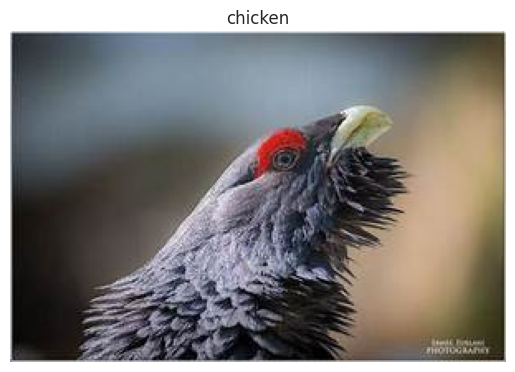

In [65]:
def images_preprocessing(filename):

    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [150, 150])
    image = image / 255.0

    image_tensor = tf.expand_dims(image, axis=0)
    return image_tensor


filename = '/content/raw-img/dataset/chicken/1170.jpeg'
image_tensor = images_preprocessing(filename=filename)

model = tf.saved_model.load('saved_model/my_model/1')
infer = model.signatures['serving_default']
predictions = infer(tf.constant(image_tensor))
prediction_index = np.argmax(predictions)

map_labels = {
    0: "chicken",
    1: "dog",
    2: "spider",
}

print(map_labels[prediction_index])
plt.imshow(original_image)
plt.axis('off')
plt.title(map_labels[prediction_index])
plt.show()

In [ ]:
import requests
def images_preprocessing(filename):

    image = tf.io.decode_image(open(filename, 'rb').read(), channels=3)
    image = tf.image.resize(image, [150, 150])
    image = image/255.

    image_tensor = tf.expand_dims(image, 0)
    image_tensor = image_tensor.numpy().tolist()

    return image_tensor

filename = 'Dataset-Final/test/cow/OIP--8_E2EnxrYh7eym5nYRTJQHaE7.jpeg'
image_tensor = images_preprocessing(filename=filename)

In [ ]:
json_data = {
    "instances": image_tensor
}

In [ ]:
endpoint = "http://localhost:8501/v1/models/my_model:predict"
response = requests.post(endpoint, json=json_data)

prediction = tf.argmax(response.json()['predictions'][0]).numpy()

map_labels = {
    0: "chicken",
    1: "dog",
    2: "spider",
}
print(map_labels[prediction])

Menampilkan semua library Python

In [66]:
!pip list

Package                            Version
---------------------------------- -------------------
absl-py                            1.4.0
accelerate                         1.2.1
aiohappyeyeballs                   2.4.4
aiohttp                            3.11.11
aiosignal                          1.3.2
alabaster                          1.0.0
albucore                           0.0.19
albumentations                     1.4.20
ale-py                             0.10.1
altair                             5.5.0
annotated-types                    0.7.0
anyio                              3.7.1
argon2-cffi                        23.1.0
argon2-cffi-bindings               21.2.0
array_record                       0.6.0
arviz                              0.20.0
astropy                            6.1.7
astropy-iers-data                  0.2025.1.27.0.32.44
astunparse                         1.6.3
atpublic                           4.1.0
attrs                              25.1.0
audioread         

Mendownload requirements.txt

In [67]:
!pip list > requirements.txt

In [68]:
!pip freeze requirements.txt

absl-py==1.4.0
accelerate==1.2.1
aiohappyeyeballs==2.4.4
aiohttp==3.11.11
aiosignal==1.3.2
alabaster==1.0.0
albucore==0.0.19
albumentations==1.4.20
ale-py==0.10.1
altair==5.5.0
annotated-types==0.7.0
anyio==3.7.1
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
array_record==0.6.0
arviz==0.20.0
astropy==6.1.7
astropy-iers-data==0.2025.1.27.0.32.44
astunparse==1.6.3
atpublic==4.1.0
attrs==25.1.0
audioread==3.0.1
autograd==1.7.0
babel==2.16.0
backcall==0.2.0
beautifulsoup4==4.12.3
bigframes==1.34.0
bigquery-magics==0.5.0
bleach==6.2.0
blinker==1.9.0
blis==0.7.11
blosc2==3.0.0
bokeh==3.6.2
Bottleneck==1.4.2
bqplot==0.12.44
branca==0.8.1
CacheControl==0.14.2
cachetools==5.5.1
catalogue==2.0.10
certifi==2024.12.14
cffi==1.17.1
chardet==5.2.0
charset-normalizer==3.4.1
chex==0.1.88
clarabel==0.9.0
click==8.1.8
cloudpathlib==0.20.0
cloudpickle==3.1.1
cmake==3.31.4
cmdstanpy==1.2.5
colorcet==3.1.0
colorlover==0.3.0
colour==0.1.5
community==1.0.0b1
confection==0.1.5
cons==0.4.6
contourpy==1.3.1
